# Experiment 1   
Description :  
* n_fft = 4096 
* Silent parts removed  
* Vocal separated  
* Two classes (Abhogi and Basant)  


# Install libraries


In [ ]:
!pip install livelossplot --quiet

In [ ]:
!pip install InaSpeechSegmenter librosa==0.8.0 

In [1]:
!pip install librosa==0.8.0 --quiet

     |████████████████████████████████| 184kB 4.8MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Image generation code / commands

In [3]:
import os
# from inaSpeechSegmenter.segmenter import Segmenter
import librosa
import librosa.display
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np
import gc

In [ ]:
def separate_speech_silence(input_file_name , intermediate_path , output_path , index):
	"""
	Removes slient parts of the audio and saves resulting wavefile to intermediate path
	"""
	seg = Segmenter()
 
	print("Segmentation start")
	segmentation = seg(input_file_name)

	print("Segmentation done")
	audio , fs = librosa.load(input_file_name)
 
	audio_result = np.array([])
	noise_result = np.array([])
	start_idx = 0
	for s in segmentation:
		if (s[0] == "music") or (s[0] == "male") or (s[0] == "female"):
			start_sample = librosa.time_to_samples(s[1])
			end_sample = librosa.time_to_samples(s[2])
			print(start_sample , "\t" , end_sample)
			audio_result = np.append(audio_result , audio[start_sample : end_sample])
		else:
			start_sample = librosa.time_to_samples(s[1])
			end_sample = librosa.time_to_samples(s[2])
			print(start_sample , "\t" , end_sample)
			noise_result = np.append(noise_result , audio[start_sample : end_sample])

	scipy.io.wavfile.write(os.path.join(intermediate_path , str(index) + ".wav") , fs , audio_result)
	scipy.io.wavfile.write(os.path.join(intermediate_path , str(index) + "_noise.wav") , fs , noise_result)
	

In [4]:
def make_spec(intermediate_path , output_path , index):
    """
    Makes spectrogram images from audio present at intermediate path and saves images at output path
    """
    stream = librosa.stream( os.path.join(intermediate_path , str(index)+".wav") , block_length=256, frame_length=2048, hop_length=1024)
    plt.margins(0,0)
    idx = 0
    for y_block in stream:

        D_block = librosa.stft(y_block, center=False ,n_fft = 4096, hop_length=64)

        fig , ax = plt.subplots()
        librosa.display.specshow(D_block , y_axis="linear" , ax=ax)
        ax.set_ylim([0,1024])
        ax.set_ylabel("")
        plt.tick_params(axis="both" ,bottom=False , left=False)
        plt.yticks()
        ax.get_yaxis().set_visible(False)

        plt.savefig(os.path.join(output_path , str(index) + "_" + str(idx) + ".png" ) , bbox_inches="tight" , format="png" , pad_inches=0)
        fig.clf()
        plt.close()
        gc.collect()
        idx += 1

In [ ]:
def generate_images(input_path , audio_path, output_path , index):
    separate_speech_silence(input_path , audio_path , output_path , index)
    make_spec(audio_path , output_path , index)


In [ ]:
file_list = ["/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/1.wav" , 
             "/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/2.wav",
             "/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/3.wav",
             "/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/4.wav",
             "/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/5.wav",
             "/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/6.wav",
             "/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/7.wav",
             "/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/8.wav",
             "/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/9.wav",
             "/gdrive/My Drive/Major Project/Images/Experiment 2/Silent split Ragas/Abhogi/10.wav"]
for idx in range(len(file_list)):
    make_spec(file_list[idx] , "/gdrive/My Drive/Major Project/Images/Experiment 1/Audio Basant" ,"/gdrive/My Drive/Major Project/Images/Experiment 1/Basant" , idx)

# Data Splitting

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
input_folder = "/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms"
output_folder = "/gdrive/My Drive/Major Project/Images/Experiment 1/Data"
splitfolders.ratio(input_folder , output=output_folder, seed=42, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 1194 files [07:09,  2.78 files/s]


# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as transforms
import torch.optim as optim
from torchvision import datasets
import os
import numpy as np
from PIL import Image
from livelossplot import PlotLosses

# Data Loading

In [ ]:
# Data transforms : Resizing , Converting to Pytorch tensor , Nomralizing the image
# data_transforms = {
#     'train' : transforms.Compose([transforms.Resize(size=(324,216)),
#                                  transforms.ToTensor(),
#                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
#     'valid': transforms.Compose([transforms.Resize(size=(324,216)),
#                                transforms.ToTensor(),
#                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
#     'test': transforms.Compose([transforms.Resize(size=(324,216)),
#                                transforms.ToTensor(),
#                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 
# }

data_transforms = {
    'train' : transforms.Compose([transforms.Resize(size=(324,216)),
                                 transforms.ToTensor(),
                                 ]),
    'valid': transforms.Compose([transforms.Resize(size=(324,216)),
                               transforms.ToTensor(),
                               ]),
    'test': transforms.Compose([transforms.Resize(size=(324,216)),
                               transforms.ToTensor(),
                               ]) 
}

main_dir = "/gdrive/My Drive/Major Project/Images/Experiment 1/Data"
train_dir = os.path.join(main_dir, "train")
test_dir = os.path.join(main_dir, "val")
valid_dir = os.path.join(main_dir, "test")

# Making dataset objects
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

batch_size = 8
num_workers = 0

# Making dataloader objects
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True,
                                           drop_last = True,)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

# Modeling


In [ ]:
"""
This method returns Sequential Conv2d with/without batch normalisation of given size, same size by default
"""
def conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, batch_norm=False):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

"""
Returns Maxpool2D, shrinks in half by default
"""
def pool(kernel_size=2, stride=2, padding=0):
    layers = []
    layers.append(nn.MaxPool2d(kernel_size, stride=stride, padding=padding))
    return nn.Sequential(*layers)

"""
Modify this to experiment on CNN architecture
Basic flow => Conv => BatchNorm => Activation => Dropout => Pooling
"""
class CNN(nn.Module):

    """
    Change in architecture must change forward function
    """
    def __init__(self, output_size=10):
        super(CNN, self).__init__()
        self.conv1 = conv(3, 32, 3, stride=1, padding=1, batch_norm=True)
        self.pool1 = pool(3, stride=3, padding=0)
        self.conv2 = conv(32, 64, 3, stride=1, padding=1, batch_norm=True)
        self.pool2 = pool(2, stride=2, padding=0)
        self.conv3 = conv(64, 64, 3, stride=1, padding=1, batch_norm=True)
        self.pool3 = pool(2, stride=2, padding=0)
        self.conv4 = conv(64, 64, 3, stride=1, padding=1, batch_norm=True)
        self.pool4 = pool(2, stride=2, padding=0)
        # TODO: write input size of FC1
        self.fc1 = nn.Linear(13*9*64, 512)
        self.fc2 = nn.Linear(512, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)                              # (324,216,3) => (324 , 216 , 32)
        x = F.relu(x)
        x = self.dropout(x)                           
        x = self.pool1(x)                              # (324 , 216 , 32) => (108 , 72 , 32)
        
        # print("Shape after 1st pooling layer " , x.shape)
        # One liner for all
        # x = self.pool2(self.dropout(F.relu(self.conv2(x))))   # (107 , 71 , 32) => (107 , 71 , 64) => (54 , 36 , 64)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.pool2(x)        
        # print("Shape after 2nd pooling layer " , x.shape)
        
        # x = self.pool3(self.dropout(F.relu(self.conv3(x))))   #(54 , 36 , 64) => (54 , 36 , 128) => (27 , 18 , 64)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.pool3(x)
        # print("Shape after 3rd pooling layer " , x.shape)
        
        # x = self.pool4(self.dropout(F.relu(self.conv4(x))))   # (13 , 9 , 64) 
        x = self.conv4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.pool4(x)
        # print("Shape after 4th pooling layer " , x.shape)
        
        # Flatten                                             
        x = x.view(-1, x.shape[3]*x.shape[1]*x.shape[2])
        # print("Shape after flattening " , x.shape)
        
        x = F.relu(self.fc1(x))
        # print("Shape after FC 1 " , x.shape)

        x = self.dropout(x)
        x = self.fc2(x)
        # x = F.relu(x)
        # print("Output after FC2 " , x)
        x = self.log_softmax(x)
        # print("Output after Softmax " , x)
        return x

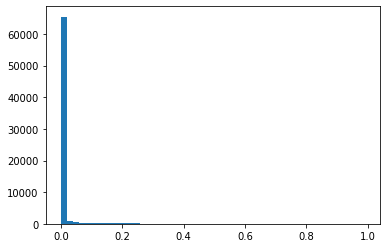

In [ ]:
import matplotlib.pyplot as plt

# print(train_data[0][0][0].reshape(-1))

plt.hist(train_data[0][0][0].reshape(-1) , bins=5)
plt.show()

# Training



In [ ]:
train_l = []
valid_l = []
def train(model, loaders, n_epochs, optimizer, criterion, device, save_path, print_every=100 , stop_after=3 , verbose=False , live_graph = False):
    valid_loss_min = np.Inf
    stop = stop_after
    
    if live_graph:
        liveloss = PlotLosses()

    for epoch in range(1, n_epochs+1):
        logs = {}
        
        train_loss = 0.0
        valid_loss = 0.0
        running_loss_t = 0.0
        running_correct_t = 0
        running_loss_v = 0.0
        running_correct_v = 0.0
        print("Epoch number start " ,str(epoch) )
        # training
        model.train()
        for batch_index, (data, target) in enumerate(loaders['train']):
            # if batch_index > 10:
            #     break
            if device == 'cuda':
                data, target = data.cuda(), target.cuda()

            if verbose:
                print("--------------------------------")
                # print("Data size " , data.shape)
                print("Target " , target)
                # print("Target size " , target.shape)

            optimizer.zero_grad()         
            pred = model(data)

            if verbose:
                print("Prediction " , pred)

            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            running_loss_t += loss.detach()*data.size(0)
            train_l.append(running_loss_t)
            # running_correct_t += torch.sum(pred == target)
            train_loss += ((1 / (batch_index + 1)) * (loss.data - train_loss))

            if batch_index%print_every == 0:
                print(f"Epoch {epoch} Batch {batch_index} loss {train_loss}")

        epoch_loss_t = running_loss_t / len(loaders["train"].dataset)
        # epoch_acc_t = running_correct_t.float() / len(loaders["train"].dataset)

        logs["log loss"] = epoch_loss_t.item()
        # logs["train accuracy"] = epoch_acc_t.item()

        # liveloss.update(logs)
        # liveloss.send()

        # validation
        model.eval()
        for batch_index, (data, target) in enumerate(loaders['valid']):
            # if batch_index > 5:
            #     break
            if device == 'cuda':
                data, target = data.cuda(), target.cuda()
            # print("VAlid data shape " , data.shape)
            
            if verbose:
                # print("Data size " , data.shape)
                print("Target " , target)
                # print("Target size " , target.shape)

            pred = model(data)
            if verbose:
                print("Prediction " , pred)

            loss = criterion(pred, target)
            running_loss_v += loss.detach()*data.size(0)
            valid_l.append(running_loss_v)
            # running_correct_v += torch.sum(pred == target)
            valid_loss += ((1 / (batch_index + 1)) * (loss.data - valid_loss))

        print(f"Epoch: {epoch} Training Loss: {train_loss} Validation Loss: {valid_loss}")

        epoch_loss_v = running_loss_v / len(loaders["valid"].dataset)
        # epoch_acc_v = running_correct_v.float() / len(loaders["valid"].dataset)

        logs["val_log loss"] = epoch_loss_v.item()
        # logs["valid accuracy"] = epoch_acc_v.item()
        
        if live_graph:
            liveloss.update(logs)
            liveloss.send()

        if valid_loss > valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print(f"Validation Loss decreased from {valid_loss_min} to {valid_loss}. Saving model...")
            valid_loss_min = valid_loss
            stop = stop_after
        else:
            stop -= 1

        if stop_after == 0:
            return model
        print("Epoch end ",str(epoch))
    return model

In [ ]:
torch.save(model.state_dict() , os.path.join("/gdrive/My Drive/Major Project/Images/Experiment 2","model_500.pt"))

In [ ]:
torch.min(train_data[88][0])

tensor(-2.1179)

# Main


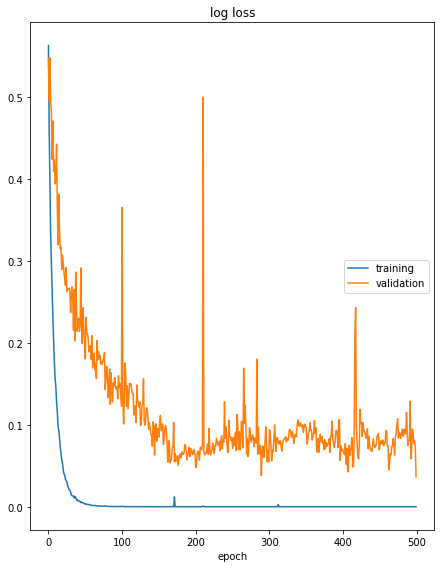

log loss
	training         	 (min:    0.000, max:    0.563, cur:    0.000)
	validation       	 (min:    0.037, max:    0.548, cur:    0.037)
Epoch end  500


In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
model = CNN(output_size=2)

if device == 'cuda':
    model = model.cuda()

# model = model.cuda()
# Loss class
criterion = torch.nn.NLLLoss()
# Optimizer class
optimizer = optim.Adam(params=model.parameters() , lr=0.00001)

model = train(model, loaders, 500 , optimizer, criterion, device, os.path.join("/gdrive/My Drive/Major Project/Images/Experiment 2","model_timepass1.pt"), print_every=100 , stop_after=5 , verbose=False , live_graph=True)
# test(model, loaders, criterion, device)

In [ ]:
def test(model, loaders, criterion, device):
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    model.eval()
    for batch_index, (data, target) in enumerate(loaders['test']):
        if device == 'cuda':
            data, target = data.cuda(), target.cuda()
        pred = model(data)
        loss = criterion(pred, target)
        test_loss += ((1 / (batch_index + 1)) * (loss.data - test_loss))
        pred = pred.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print(f"Test loss {test_loss}")
    print(f"Testing accuracy {correct/total}")

In [ ]:
# model = torch.load(os.path.join("/gdrive/My Drive/Major Project/Images/Experiment 1","model.pt"))
# model = CNN(output_size = 2)
# model.load_state_dict(torch.load(os.path.join("/gdrive/My Drive/Major Project/Images/Experiment 2","model.pt")))
# model = model.cuda()
test(model, loaders, criterion, device)

Test loss 0.117258220911026
Testing accuracy 0.9663865546218487


# LSTM data preparation

In [ ]:
"""
Making a dataframe of all spectrogram files' path and their class
"""
import pandas as pd

path_df = pd.DataFrame(columns=["Path" , "Name" , "Raga"])
paths = []
names = []
ragas = []

dataset_path = "/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms"

for file_name in os.listdir(os.path.join(dataset_path , "Abhogi")):
    paths.append(os.path.join(dataset_path , "Abhogi" , file_name))
    names.append(file_name.split("_")[0])
    ragas.append("Abhogi")

for file_name in os.listdir(os.path.join(dataset_path , "Basant")):
    paths.append(os.path.join(dataset_path , "Basant" , file_name))
    names.append(file_name.split("_")[0])
    ragas.append("Basant")

path_df.Path = paths
path_df.Name = names
path_df.Raga = ragas

path_df.to_csv(dataset_path + str("/file.csv"))

raga_name_groupby = path_df.groupby(by=["Raga" , "Name"])
# print(raga_name_groupby.count())

In [ ]:
"""
Making sequences from the input 
"""
def batch_data(words, sequence_length, batch_size , raga_name , features , target):    
    n_targets = len(words) - sequence_length
    
    if n_targets < 1:
        return 
    
    for i in range(n_targets):
        end_idx = i + sequence_length
        
        batch = words[i : end_idx]
        features.append(batch)
        target.append(raga_name)
        
    return features , target

In [ ]:
"""
Saving pickle files of sequences of paths
"""
import pickle

raga_names = ["Abhogi"]

for raga_name in raga_names:
    features = []
    target = []
    for i in range(1,11):
        # print("Starting " , i)
        features , target = batch_data(list(raga_name_groupby.get_group((raga_name,str(i))).Path) , 3 , 1 , raga_name , features , target)
        # print("Ending " , i)
    
    # print(len(target))
    with open(os.path.join("/gdrive/My Drive/Major Project/Images/Experiment 1/Paths" , raga_name + "_feature") , "wb") as f:
        pickle.dump(features , f)
    with open(os.path.join("/gdrive/My Drive/Major Project/Images/Experiment 1/Paths" , raga_name + "_target") , "wb") as f:
        pickle.dump(target , f)
print(features)

[['/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_0.png', '/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_1.png', '/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_2.png'], ['/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_1.png', '/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_2.png', '/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_3.png'], ['/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_2.png', '/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_3.png', '/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_4.png'], ['/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_3.png', '/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_4.png', '/gdrive/My Drive/Major Project/Images/Experiment 1/Spectrograms/Abhogi/1_5.png'], ['/gdri

In [ ]:
"""
Loading pickle files
"""
import pickle
abhogi_fv = pickle.load(open("/gdrive/My Drive/Major Project/Images/Experiment 1/Paths/Abhogi_feature" , "rb"))
abhogi_t = pickle.load(open("/gdrive/My Drive/Major Project/Images/Experiment 1/Paths/Abhogi_target" , "rb"))
basant_fv = pickle.load(open("/gdrive/My Drive/Major Project/Images/Experiment 1/Paths/Basant_feature" , "rb"))
basant_t = pickle.load(open("/gdrive/My Drive/Major Project/Images/Experiment 1/Paths/Basant_target" , "rb"))

In [ ]:
"""
Train test split
"""
from sklearn.model_selection import train_test_split

X_train ,  X_test , y_train ,y_test = train_test_split(abhogi_fv + basant_fv , abhogi_t + basant_t , test_size = 0.2)
X_valid ,  X_test , y_valid ,y_test = train_test_split(X_test ,y_test, test_size = 0.5)

print(len(X_train))
# print(X_train)
print(len(X_valid))
print(len(X_test))

907
113
114


In [ ]:
"""
Custom Dataset class inheriting abstract Dataset class
"""
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self , x , y , cnn_model , test_transforms):
        self.x = x
        self.y = y
        self.cnn_model = cnn_model
        self.cnn_model.eval()
        self.test_transforms = test_transforms

    def __len__(self):
        return(len(self.x))

    def __getitem__(self , idx):
        """
        Returns sequence of feature vectors by getting output from cnn model
        """
        arr = self.x[idx]
        out = []
        for path in arr:
            with open(path, 'rb') as f:
                img = Image.open(f)
                img = img.convert('RGB')
            img = self.test_transforms(img)
            
            output = self.cnn_model(img.unsqueeze(0))
            output = output.reshape(-1,13*9*64)
            out.append(output)
            
        if self.y[idx] == "Abhogi":
            t = torch.Tensor([0]).long()
        else:
            t= torch.Tensor([1]).long()

        return torch.stack(out) , t


# Transforms
test_transforms = transforms.Compose([transforms.Resize(size=(324,216)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Loading the CNN model and removing the fully connected layers
model = CNN(output_size = 2)
model.load_state_dict(torch.load(os.path.join("/gdrive/My Drive/Major Project/Images/Experiment 2","model_500.pt") ,  map_location=torch.device('cpu')))

cnn_model = nn.Sequential(*list(model.children())[:8])

# Making dataset objects
train_dataset = SequenceDataset(X_train , y_train , cnn_model , test_transforms)
valid_dataset = SequenceDataset(X_valid , y_valid , cnn_model , test_transforms)
test_dataset = SequenceDataset(X_test , y_test , cnn_model , test_transforms)



In [ ]:
# Making Dataloader objects
loaders = {
    "train" : torch.utils.data.DataLoader(train_dataset,
                                           batch_size=1, 
                                           num_workers=0,
                                           shuffle=True,
                                           drop_last = False) ,
    "valid" : torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=1, 
                                           num_workers=0,
                                           shuffle=True,
                                           drop_last = False) ,
    "test" : torch.utils.data.DataLoader(test_dataset,
                                           batch_size=1, 
                                           num_workers=0,
                                           shuffle=True,
                                           drop_last = False)
}

# LSTM Modeling

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self , input_size = 1 , hidden_layer_size = 256 , output_size = 2):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size , hidden_layer_size)
        self.fc = nn.Linear(hidden_layer_size , output_size)
        self.log_softmax = nn.LogSoftmax(dim=0)

    def forward(self , input_seq , hidden_cell):
        self.lstm.flatten_parameters()
        
        # hidden_cell = (torch.zeros(1,1,256).cuda(),
        #             torch.zeros(1,1,256).cuda())
        # print(input_seq[:10])
        lstm_out , hidden_cell = self.lstm(input_seq , hidden_cell)
        lstm_output = lstm_out.view(-1, self.hidden_layer_size)
        lstm_output = lstm_output[-1,:]
        # print(lstm_output.shape)
        model_output = self.fc(lstm_output)
        # print(model_output.shape)
        probabilities = self.log_softmax(model_output)
        return probabilities , hidden_cell
        

# LSTM training

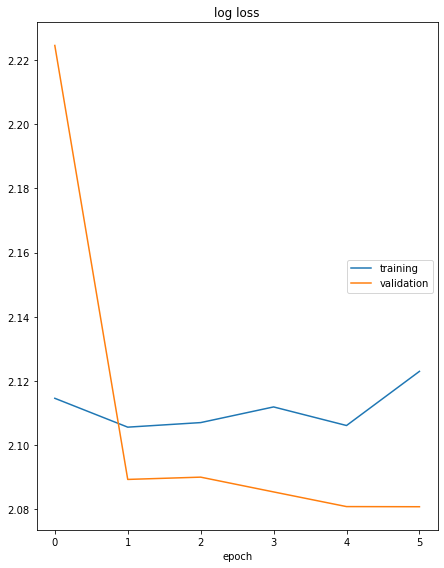

log loss
	training         	 (min:    2.106, max:    2.123, cur:    2.123)
	validation       	 (min:    2.081, max:    2.225, cur:    2.081)
Validation Loss decreased from 0.6936005353927612 to 0.6935862302780151. Saving model...
Epoch end  6
Epoch number start  7
Epoch 7 Batch 0 loss 0.6002627611160278
Epoch 7 Batch 10 loss 0.6476321220397949
Epoch 7 Batch 20 loss 0.6688902378082275
Epoch 7 Batch 30 loss 0.723082959651947
Epoch 7 Batch 40 loss 0.7183831930160522
Epoch 7 Batch 50 loss 0.7142100930213928
Epoch 7 Batch 60 loss 0.7104620933532715
Epoch 7 Batch 70 loss 0.7008575201034546
Epoch 7 Batch 80 loss 0.6767311096191406
Epoch 7 Batch 90 loss 0.6895903944969177
Epoch 7 Batch 100 loss 0.7104950547218323
Epoch 7 Batch 110 loss 0.712246835231781
Epoch 7 Batch 120 loss 0.707721471786499
Epoch 7 Batch 130 loss 0.7053019404411316
Epoch 7 Batch 140 loss 0.6993225812911987
Epoch 7 Batch 150 loss 0.702275812625885
Epoch 7 Batch 160 loss 0.7061882019042969
Epoch 7 Batch 170 loss 0.70329904556

KeyboardInterrupt: ignored

In [ ]:
model_seq = LSTMModel(input_size = 7488)

criterion = torch.nn.NLLLoss()
optimizer = optim.Adam(params=model_seq.parameters())

model_seq = model_seq.cuda()
model_seq = train_lstm(model_seq  , loaders , 10 , optimizer , criterion , "cuda" , os.path.join("/gdrive/My Drive/Major Project/Images/Experiment 1","lstm_model_cnn500.pt") , print_every = 10)


In [ ]:
def train_lstm(model , loader , n_epochs , optimizer , criterion , device , save_path , print_every=100 , stop_after = 3):
    valid_loss_min = np.Inf
    stop = stop_after
    hidden_cell = (torch.zeros(1,1,256).cuda(),
                    torch.zeros(1,1,256).cuda())
    # hidden_cell = hidden_cell.cuda()
    # if live_graph:
    liveloss = PlotLosses()

    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        print("Epoch number start " ,str(epoch) )
        # training
        model.train()
        logs = {}
        running_loss_t = 0.0
        running_correct_t = 0
        running_loss_v = 0.0
        running_correct_v = 0.0
        for batch_index, (data, target) in enumerate(loader["train"]):    # for sequence in sequences
            if device == 'cuda':
                data, target = data.cuda(), target.cuda()
            data = torch.squeeze(data , dim=0)
            # print("Data size " , data.shape)
            target = torch.squeeze(target , dim=0)
            # print("Target size " , target.shape)
            # print("Target " , target)

            optimizer.zero_grad()         
            pred , hidden_cell_ = model(data , hidden_cell)
            pred = torch.unsqueeze(pred , 0)

            # print("Pred " , pred.shape)
            # print("Prediction" , pred)
            
            # hidden_cell[0].detach_()
            # hidden_cell[1].detach_()

            # print("Predicted " , pred , " Target " , target)
            loss = criterion(pred, target)
            running_loss_t += loss.detach()*data.size(0)
            # model.train()
            loss.backward()
            optimizer.step()

            train_loss += ((1 / (batch_index + 1)) * (loss.data - train_loss))

            if batch_index%print_every == 0:
                print(f"Epoch {epoch} Batch {batch_index} loss {train_loss}")

        epoch_loss_t = running_loss_t / len(loader["train"].dataset)
        logs["log loss"] = epoch_loss_t.item()
        # validation
        model.eval()
        with torch.no_grad():
            for batch_index, (data, target) in enumerate(loader['valid']):
                if device == 'cuda':
                    data, target = data.cuda(), target.cuda()
                # print("VAlid data shape " , data.shape)
                data = torch.squeeze(data , dim=0)
                target = torch.squeeze(target , dim=0)

                pred , hidden_cell = model(data , hidden_cell)
                pred = torch.unsqueeze(pred , 0)

                loss = criterion(pred , target)
                running_loss_v += loss.detach() * data.size(0)
                valid_loss += ((1 / (batch_index + 1)) * (loss.data - valid_loss))
        epoch_loss_v = running_loss_v / len(loader["valid"].dataset)
        logs["val_log loss"] = epoch_loss_v.item()
        print(f"Epoch: {epoch} Training Loss: {train_loss} Validation Loss: {valid_loss}")
        liveloss.update(logs)
        liveloss.send()
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print(f"Validation Loss decreased from {valid_loss_min} to {valid_loss}. Saving model...")
            valid_loss_min = valid_loss
            stop_after = stop
        else:
            stop_after -= 1

        if stop_after == 0:
            return model
        print("Epoch end ",str(epoch))
    return model

In [ ]:
import gc
gc.collect()

899

In [ ]:
def test(model, loaders, criterion, device):
    test_loss = 0.0
    correct = 0.0
    total = 0.0
    
    
    model.eval()
    for batch_index, (data, target) in enumerate(loaders['test']):
        if device == 'cuda':
            data, target = data.cuda(), target.cuda()
        data = torch.squeeze(data , dim=0)
        target = torch.squeeze(target , dim=0)
        
        hidden_cell = (torch.zeros(1,1,256).cuda(),
                    torch.zeros(1,1,256).cuda())
        
        pred  , hidden_cell = model(data , hidden_cell)
        pred = torch.unsqueeze(pred , 0)

        print("Prediction " , pred , " Target " , target)
        loss = criterion(pred, target)
        test_loss += ((1 / (batch_index + 1)) * (loss.data - test_loss))
        pred = pred.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print(f"Test loss {test_loss}")
    print(f"Testing accuracy {correct/total}")

In [ ]:
model_path = "/gdrive/My Drive/Major Project/Images/Experiment 1/lstm_model.pt"

model = LSTMModel(input_size=7488)
model.load_state_dict(torch.load(os.path.join("/gdrive/My Drive/Major Project/Images/Experiment 1","lstm_model.pt")))
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
test(model, loaders, criterion, "cuda")

tensor([[[2.2063, 2.5717, 2.6743,  ..., 1.3967, 1.3616, 0.9110]],

        [[2.1732, 2.6442, 2.6574,  ..., 1.4135, 1.3973, 1.0128]],

        [[2.1072, 2.5737, 2.4711,  ..., 1.5206, 1.5285, 1.0942]]],
       device='cuda:0', grad_fn=<SliceBackward>)
Prediction  tensor([[0.6223, 0.3777]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)  Target  tensor([1], device='cuda:0')
tensor([[[2.2189, 2.6144, 2.5751,  ..., 1.1925, 1.2059, 0.9625]],

        [[1.8403, 2.4216, 2.4074,  ..., 1.5296, 1.5316, 1.0789]],

        [[1.4118, 1.7334, 2.4824,  ..., 1.4117, 1.4619, 1.0462]]],
       device='cuda:0', grad_fn=<SliceBackward>)
Prediction  tensor([[0.6223, 0.3777]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)  Target  tensor([0], device='cuda:0')
tensor([[[2.0904, 2.5838, 2.6120,  ..., 1.3173, 1.2219, 0.9045]],

        [[2.1722, 2.5863, 2.5882,  ..., 1.1711, 1.1668, 0.8438]],

        [[2.3033, 2.6930, 2.6991,  ..., 1.2107, 1.2031, 0.8463]]],
       device='cuda:0', grad_fn=<SliceBackward>)
Pr